In [25]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from lmfit.models import LinearModel
from rgaplot.pvstscan import PvsTScan

## Plotly Templating

In [2]:
# options for live figures
config = {
    "scrollZoom": True,
    "toImageButtonOptions": {
        "format": "svg",
        "scale": 2,
    },
}

# Need this so cell outputs work in Quarto
pio.renderers.default = "notebook"

# Register figure template
temp1 = go.layout.Template()

temp1.layout.update(
    {
        "margin": dict(l=70, r=10, t=10, b=50),
        "font": dict(size=14),
        "width": 600,
        "height": 400,
        "autosize": False,
        "xaxis": dict(
            showline=True,
            linewidth=1,
            linecolor="black",
            mirror=True,
            exponentformat="E",
            showexponent="all",
        ),
        "yaxis": dict(showline=True, linewidth=1, linecolor="black", mirror=True),
        "modebar_add": ["hoverclosest", "hovercompare"],
    }
)

pio.templates["temp1"] = temp1

pio.templates["presentation"].data.scatter = [go.Scatter(line_width=1)]

## Calibration Curve Ratios

In [3]:
cal_df = pd.read_csv("rga-cal-factors.csv")
# copied from https://drive.google.com/drive/folders/1pmM_4vTutLIQSBij7U8TxTE4MUPGT5X7
scan_path = "/home/emiz/projects/projectdata/CHILLAX/theranos/samplingdata/"
cal_df["FilePath"] = scan_path + cal_df["FilePath"]

In [4]:
scans = [PvsTScan(path) for path in cal_df["FilePath"]]


# Set parameters on scans from calibrate csv
# Need to manually determine time periods to use since sometimes there's a change in an abrupt change in valve state
[
    setattr(scan, "time_data_range", [t_l, t_h])
    for t_l, t_h, scan in zip(cal_df["t_low_s"], cal_df["t_high_s"], scans)
]

[
    setattr(scan, "outlier_percent_exclude", [t_l, t_h])
    for t_l, t_h, scan in zip(
        cal_df["outlier_low_frac"], cal_df["outlier_high_frac"], scans
    )
];  # fmt: skip

In [5]:
# get dfs with rga response
# get_ratio applies cuts set above

ratios = pd.concat([scan.get_ratio(["129.00"], ["40.00"]) for scan in scans])
scanparams = pd.concat([scan.get_scan_parameters() for scan in scans])

# Make a df with mean and std data for each scan
data_df = ratios.groupby("Timestamp")[["ratio"]].mean().reset_index()
data_df["ratio_std"] = (
    ratios.groupby("Timestamp")[["ratio"]].std().reset_index()["ratio"]
)

# Merge all data frames so we have data from cal_df, ratios, and scanparams together
cal_df = pd.merge(cal_df, scanparams, how="left", on="FilePath")
data_df = pd.merge(data_df, cal_df, on="Timestamp", how="left")

data_df.columns

Index(['Timestamp', 'ratio', 'ratio_std', 'FilePath', 't_low_s', 't_high_s',
       'outlier_low_frac', 'outlier_high_frac', 'calibrate', 'comments',
       'Active channels in Scan', 'Units', 'Sample Period', 'Focus Voltage',
       'Ion Energy', 'Electron Energy', 'CEM Voltage', 'CEM Gain',
       'Sensitivity Factor', 'Filament Current', 'ExpectedPPM',
       'InletPressure(torr)', 'Scan Type'],
      dtype='object')

## Calculating Fit

In [6]:
# Fit only to points selected for calibration

fit_df = data_df[data_df["calibrate"] == True]
lin_mod = LinearModel()

fit_params = lin_mod.make_params()
fit_params["intercept"].value = 0
fit_params["intercept"].vary = False

fit_result = lin_mod.fit(
    data=fit_df["ExpectedPPM"],
    x=fit_df["ratio"] * 1e6,
    params=fit_params,
)
fit_result

In [7]:
# | label: rga-cal-curve

fig = px.scatter(
    data_frame=data_df,
    x="ratio",
    y="ExpectedPPM",
    range_y=(0, 55),
    error_x="ratio_std",
    color="InletPressure(torr)",
    symbol="calibrate",
    labels={
        "ratio": "129/40 RGA Response",
        "ExpectedPPM": "Xenon Mole Fraction x 10<sup>6</sup>",
        "calibrate": "Calibration Data",
        "InletPressure(torr)": "Inlet Pressure [torr]",
    },
)

fit_trace = go.Scatter(
    x=fit_df["ratio"],
    y=fit_result.eval(),
    mode="lines",
    name=f"m = {fit_result.params['slope'].value:.3g} ± {fit_result.params['slope'].stderr:.1g} <br> b = {fit_result.params['intercept'].value:.2g}",
)

fig.add_traces([fit_trace])

# need to force update with temp layout
fig.layout.update(temp1.layout.to_plotly_json())
fig.update_traces(marker_size=10)
fig.update_layout(
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    template="presentation",
    coloraxis_colorbar=dict(titleside="right"),
    coloraxis_colorscale="viridis",
)
fig.show(config=config)

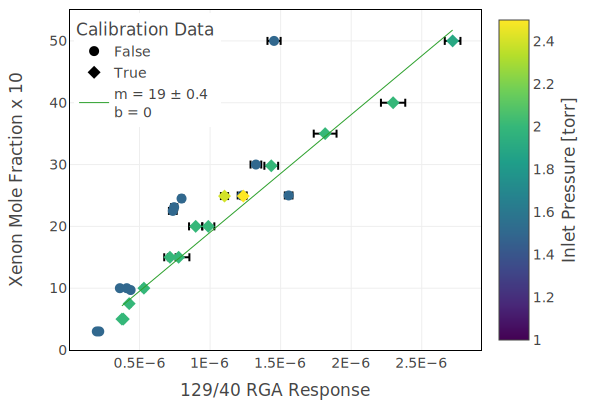

In [8]:
# | label: rga-cal-curve-svg

fig.show(renderer="svg")

In [9]:
# | label: rga-cal-curve-df

data_df[
    [
        "Timestamp",
        "calibrate",
        "ExpectedPPM",
        "InletPressure(torr)",
        "ratio",
        "ratio_std",
    ]
]

Timestamp  calibrate  ExpectedPPM  InletPressure(torr)         ratio  \
0   1644614821      False         30.0                  1.5  1.324770e-06   
1   1645218380      False         23.1                  1.5  7.454198e-07   
2   1645223430      False         22.5                  1.5  7.360033e-07   
3   1645230028      False         25.0                  1.5  1.227635e-06   
4   1645647642      False         24.5                  1.5  7.978726e-07   
5   1645662065      False         10.0                  1.5  4.095618e-07   
6   1645667228      False          9.7                  1.5  4.368858e-07   
7   1645817242      False         10.0                  1.5  3.607404e-07   
8   1645840492      False         50.0                  1.5  1.453398e-06   
9   1647466827      False          3.0                  1.5  2.147244e-07   
10  1647475873      False          3.0                  1.5  1.972583e-07   
11  1647636135      False         25.0                  1.5  1.556843e-06   
12  1650486402       True         24.9                  2.4  1.102273e-06   
13  1650497722       True         24.9                  2.5  1.235530e-06   
14  1650501034       True         50.0                  1.9  2.718841e-06   
15  1650651641       True         10.0                  2.0  5.310693e-07   
16  1650656653       True          5.0                  2.0  3.848940e-07   
17  1650664549       True          5.0                  2.0  3.751306e-07   
18  1650671157       True          7.5                  2.0  4.266358e-07   
19  1651085260       True         15.0                  2.0  7.154542e-07   
20  1651090854       True         29.8                  2.0  1.433662e-06   
21  1651101453       True         20.0                  2.0  8.978739e-07   
22  1651105322       True         35.0                  2.0  1.815492e-06   
23  1651258645       True         15.0                  2.0  7.771268e-07   
24  1651267255       True         20.0                  2.0  9.874322e-07   
25  1651273653       True         40.0                  2.0  2.297140e-06   

       ratio_std  
0   3.796895e-08  
1   2.212347e-08  
2   2.765962e-08  
3   3.189264e-08  
4   1.516191e-08  
5   1.009965e-08  
6   1.097701e-08  
7   9.652101e-09  
8   4.664122e-08  
9   7.230886e-09  
10  5.830452e-09  
11  2.715186e-08  
12  2.529723e-08  
13  1.960153e-08  
14  5.556523e-08  
15  9.741818e-09  
16  8.732218e-09  
17  7.920147e-09  
18  8.812230e-09  
19  4.034751e-08  
20  4.877025e-08  
21  4.690763e-08  
22  8.077137e-08  
23  7.631715e-08  
24  4.276348e-08  
25  8.616283e-08

## Stability Study Measurements

In [30]:
cal_df = pd.read_csv("stability-study-samples.csv")
# copied from https://drive.google.com/drive/folders/1pmM_4vTutLIQSBij7U8TxTE4MUPGT5X7
scan_path = "/home/emiz/projects/projectdata/CHILLAX/theranos/samplingdata/"
cal_df["FilePath"] = scan_path + cal_df["FilePath"]

In [31]:
scans = [PvsTScan(path) for path in cal_df["FilePath"]]


# Set parameters on scans from calibrate csv
# Need to manually determine time periods to use since sometimes there's a change in an abrupt change in valve state
[
    setattr(scan, "time_data_range", [t_l, t_h])
    for t_l, t_h, scan in zip(cal_df["t_low_s"], cal_df["t_high_s"], scans)
]

[
    setattr(scan, "outlier_percent_exclude", [t_l, t_h])
    for t_l, t_h, scan in zip(
        cal_df["outlier_low_frac"], cal_df["outlier_high_frac"], scans
    )
];  # fmt: skip

# get dfs with rga response
# get_ratio applies cuts set above

ratios = pd.concat([scan.get_ratio(["129.00"], ["40.00"]) for scan in scans])
scanparams = pd.concat([scan.get_scan_parameters() for scan in scans])

In [32]:
# Make a df with mean and std data for each scan
data_df = ratios.groupby("Timestamp")[["ratio"]].mean().reset_index()
data_df["ratio_std"] = (
    ratios.groupby("Timestamp")[["ratio"]].std().reset_index()["ratio"]
)

# Merge all data frames so we have data from cal_df, ratios, and scanparams together
cal_df = pd.merge(cal_df, scanparams, how="left", on="FilePath")
data_df = pd.merge(data_df, cal_df, on="Timestamp", how="inner")

# Make a datetime column; needs to be tz-aware before converting to west coast
data_df["datetime"] = pd.to_datetime(data_df["Timestamp"], unit="s", utc=True)
data_df["datetime"] = data_df["datetime"].dt.tz_convert(tz="America/Los_Angeles")

# Number of Samples Per Scan
data_df["n_samples"] = ratios.groupby("Timestamp").count().reset_index()["ratio"]

# Convert to ppm using calibration factor (worry about uncertainties later)
data_df["ratio"] = fit_result.params["slope"].value * 1e6 * data_df["ratio"]
data_df["ratio_std"] = (
    fit_result.params["slope"].value * 1e6 * data_df["ratio_std"]
)  # / np.sqrt(data_df["n_samples"])

data_df.columns

Index(['Timestamp', 'ratio', 'ratio_std', 'FilePath', 't_low_s', 't_high_s',
       'outlier_low_frac', 'outlier_high_frac', 'ice', 'enabled',
       'doping_frac', 'comments', 'Active channels in Scan', 'Units',
       'Sample Period', 'Focus Voltage', 'Ion Energy', 'Electron Energy',
       'CEM Voltage', 'CEM Gain', 'Sensitivity Factor', 'Filament Current',
       'ExpectedPPM', 'InletPressure(torr)', 'Scan Type', 'datetime',
       'n_samples'],
      dtype='object')

In [33]:
# | label: rga-run13-measurements

fig = px.scatter(
    data_frame=data_df,
    y="ratio",
    x="datetime",
    error_y="ratio_std",
    color="InletPressure(torr)",
    symbol="ice",
    labels={
        "ratio": "Xenon Vapor Mole Fraction x 10<sup>6</sup>",
        "doping_frac": "Xenon Liquid Mole Fraction x 10<sup>6</sup>",
        "ice": "Ice Present",
        "datetime": "Date",
        "InletPressure(torr)": "Inlet Pressure [torr]",
    },
)

# Highlight days with grey bars
for i in range(1, 15):
    if i % 2 == 0:
        fill = "grey"
    else:
        fill = None
    fig.add_vrect(
        x0=f"2022-06-{i}",
        x1=f"2022-06-{i+1}",
        fillcolor=fill,
        opacity=0.25,
        line_width=0,
        layer="below",
    )

# need to force update with temp layout
fig.layout.update(temp1.layout.to_plotly_json())
# fig.update_traces(marker_size=10)
fig.update_layout(
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    template="presentation",
    coloraxis_colorbar=dict(titleside="right"),
    coloraxis_colorscale="viridis",
)
fig.show(config=config)

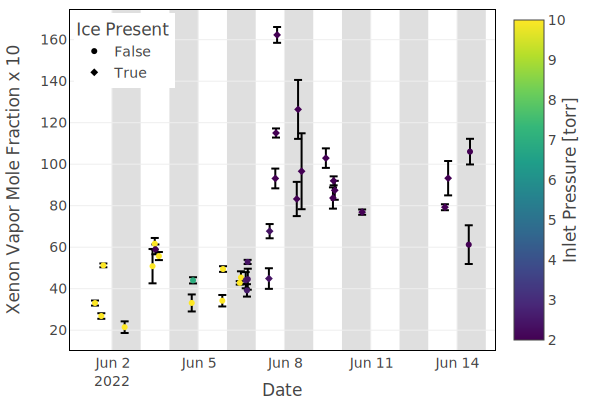

In [34]:
# | label: rga-run13-measurements-svg

fig.show(renderer="svg")

In [35]:
# Ratio of first scan to last scan
# First scan is usually lower

data_df.groupby(data_df["datetime"].dt.date).head(1).reset_index()[
    "ratio"
] / data_df.groupby(data_df["datetime"].dt.date).tail(1).reset_index()["ratio"]

0     0.645622
1     1.000000
2     0.912510
3     0.752511
4     0.691328
5     0.960521
6     0.276608
7     0.861623
8     1.177298
9     1.000000
10    0.849976
11    0.577404
Name: ratio, dtype: float64